<a href="https://colab.research.google.com/github/grlee1128/DS340W/blob/main/DS_340W_ParentPaper_Code_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
rohitrox_healthcare_provider_fraud_detection_analysis_path = kagglehub.dataset_download('rohitrox/healthcare-provider-fraud-detection-analysis')

print('Data source import complete.')

#If this does not connect to kaggle page just download files from that kaggle page

Data source import complete.


In [25]:
#import libraries that needed

#libraries for data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Install required package
!pip install category_encoders

#libraries for statistics
from scipy.stats import chi2_contingency

#libraries for modelling
#preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE
#machine learning
import tensorflow as tf
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import Binarizer
#evaluation
from sklearn.metrics import f1_score

#library for preventing warnings
import warnings
warnings.filterwarnings('ignore')


## LOAD DATA

In [26]:
# Load Train Dataset

Train=pd.read_csv("Train-1542865627584.csv")
Train_Beneficiarydata=pd.read_csv("Train_Beneficiarydata-1542865627584.csv")
Train_Inpatientdata=pd.read_csv("Train_Inpatientdata-1542865627584.csv")
Train_Outpatientdata=pd.read_csv("Train_Outpatientdata-1542865627584.csv")

# Load Test Dataset

Test=pd.read_csv("Test-1542969243754.csv")
Test_Beneficiarydata=pd.read_csv("Test_Beneficiarydata-1542969243754.csv")
Test_Inpatientdata=pd.read_csv("Test_Inpatientdata-1542969243754.csv")
Test_Outpatientdata=pd.read_csv("Test_Outpatientdata-1542969243754.csv")


In [27]:
## Get information of aligndatasets

print('Info of Train data :')
Train.info()
print('\n------------------------------------------------------------------------------------\n')
print('Info of Train_Beneficiarydata data :')
Train_Beneficiarydata.info()
print('\n------------------------------------------------------------------------------------\n')
print('Info of Train_Inpatientdata data :')
Train_Inpatientdata.info()
print('\n------------------------------------------------------------------------------------\n')
print('Info of Train_Outpatientdata data :')
Train_Outpatientdata.info()
print('\n------------------------------------------------------------------------------------\n')
print('Info of Test data :')
Test.info()
print('\n------------------------------------------------------------------------------------\n')
print('Info of Test_Beneficiarydata data :')
Test_Beneficiarydata.info()
print('\n------------------------------------------------------------------------------------\n')
print('Info of Test_Inpatientdata data :')
Test_Inpatientdata.info()
print('\n------------------------------------------------------------------------------------\n')
print('Info of Test_Outpatientdata data :')
Test_Outpatientdata.info()

Info of Train data :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5410 entries, 0 to 5409
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Provider        5410 non-null   object
 1   PotentialFraud  5410 non-null   object
dtypes: object(2)
memory usage: 84.7+ KB

------------------------------------------------------------------------------------

Info of Train_Beneficiarydata data :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138556 entries, 0 to 138555
Data columns (total 25 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   BeneID                           138556 non-null  object
 1   DOB                              138556 non-null  object
 2   DOD                              1421 non-null    object
 3   Gender                           138556 non-null  int64 
 4   Race                             138556 non-

# Get training Data

In [28]:
#merge all training data.
df_train = Train.merge(Train_Inpatientdata, how = 'left', on = 'Provider')
df_train = df_train.merge(Train_Outpatientdata, how = 'left', on = ['Provider', 'BeneID', 'ClaimID'])
df_train = df_train.merge(Train_Beneficiarydata, how = 'left', on = 'BeneID')

In [29]:
df_train.shape

(43792, 79)

In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43792 entries, 0 to 43791
Data columns (total 79 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Provider                         43792 non-null  object 
 1   PotentialFraud                   43792 non-null  object 
 2   BeneID                           40474 non-null  object 
 3   ClaimID                          40474 non-null  object 
 4   ClaimStartDt_x                   40474 non-null  object 
 5   ClaimEndDt_x                     40474 non-null  object 
 6   InscClaimAmtReimbursed_x         40474 non-null  float64
 7   AttendingPhysician_x             40362 non-null  object 
 8   OperatingPhysician_x             23830 non-null  object 
 9   OtherPhysician_x                 4690 non-null   object 
 10  AdmissionDt                      40474 non-null  object 
 11  ClmAdmitDiagnosisCode_x          40474 non-null  object 
 12  DeductibleAmtPaid_

# Add Num of Claims Features

In [31]:
# Assign claim to 1 and null claim to 0
df_train[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']] = df_train[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].where(~df_train[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].notna(), 1)
df_train[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']] = df_train[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].where(df_train[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].notna(), 0)

#change type of columns from string into int
df_train[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']] = df_train[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].astype('int64')

# Sum number of claims
claim_diagnose = []

for i in range(len(df_train)):
    claim_diagnose.append(df_train['ClmDiagnosisCode_1_x'][i]+ df_train['ClmDiagnosisCode_2_x'][i]+ df_train['ClmDiagnosisCode_3_x'][i]+ df_train['ClmDiagnosisCode_4_x'][i]+ df_train['ClmDiagnosisCode_5_x'][i]+ df_train['ClmDiagnosisCode_6_x'][i]+ df_train['ClmDiagnosisCode_7_x'][i]+df_train['ClmDiagnosisCode_8_x'][i]+  df_train['ClmDiagnosisCode_9_x'][i]+ df_train['ClmDiagnosisCode_10_x'][i])

#Put into a column.
df_train['num_claim_diagnose_in'] = claim_diagnose

# Assign claim to 1 and null claim to 0
df_train[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']] = df_train[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].where(~df_train[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].notna(), 1)
df_train[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']] = df_train[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].where(df_train[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].notna(), 0)

#change type of columns from string into int
df_train[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']] = df_train[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].astype('int64')

# Sum number of claims
claim_diagnose = []

for i in range(len(df_train)):
    claim_diagnose.append(df_train['ClmDiagnosisCode_1_y'][i]+ df_train['ClmDiagnosisCode_2_y'][i]+ df_train['ClmDiagnosisCode_3_y'][i]+ df_train['ClmDiagnosisCode_4_y'][i]+ df_train['ClmDiagnosisCode_5_y'][i]+ df_train['ClmDiagnosisCode_6_y'][i]+ df_train['ClmDiagnosisCode_7_y'][i]+df_train['ClmDiagnosisCode_8_y'][i]+  df_train['ClmDiagnosisCode_9_y'][i]+ df_train['ClmDiagnosisCode_10_y'][i])

#Put into a column.
df_train['num_claim_diagnose_out'] = claim_diagnose

# Assign claim to 1 and null claim to 0
df_train[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']] = df_train[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].where(~df_train[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].notna(), 1)
df_train[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']] = df_train[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].where(df_train[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].notna(), 0)

#change type of columns from string into int
df_train[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']] = df_train[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].astype('int64')

# Sum number of claims
claim_procedure = []

for i in range(len(df_train)):
    claim_procedure.append(df_train['ClmProcedureCode_1_x'][i]+ df_train['ClmProcedureCode_2_x'][i]+ df_train['ClmProcedureCode_3_x'][i]+ df_train['ClmProcedureCode_4_x'][i]+ df_train['ClmProcedureCode_5_x'][i])

#Put into a column.
df_train['num_claim_procedure_in'] = claim_procedure

# Assign claim to 1 and null claim to 0
df_train[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']] = df_train[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].where(~df_train[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].notna(), 1)
df_train[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']] = df_train[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].where(df_train[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].notna(), 0)

#change type of columns from string into int
df_train[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']] = df_train[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].astype('int64')

# Sum number of claims
claim_procedure = []

for i in range(len(df_train)):
    claim_procedure.append(df_train['ClmProcedureCode_1_y'][i]+ df_train['ClmProcedureCode_2_y'][i]+ df_train['ClmProcedureCode_3_y'][i]+ df_train['ClmProcedureCode_4_y'][i]+ df_train['ClmProcedureCode_5_y'][i])

#Put into a column.
df_train['num_claim_procedure_out'] = claim_procedure

# Map Attending columns

#### Attending Physician, Operating Physician, and Other Physician

In [32]:
df_train[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']] = df_train[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].where(~df_train[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].notna(), 1)
df_train[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']] = df_train[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].where(df_train[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].notna(), 0)
df_train[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']] = df_train[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].where(~df_train[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].notna(), 1)
df_train[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']] = df_train[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].where(df_train[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].notna(), 0)

df_train[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']] = df_train[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].astype('int64')
df_train[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']] = df_train[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].astype('int64')

# Mapping Chronic Disease Columns

In [33]:
##Replacing 2 with 0 for chronic conditions ,that means chroniv condition No is 0 and yes is 1

df_train = df_train.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)


# Groupby Provider and Potential Fraud

In [34]:
# Drop demographic columns if present
cols_to_drop = ['Gender', 'Race', 'State', 'County']
existing_cols = [col for col in cols_to_drop if col in df_train.columns]
df_train.drop(columns=existing_cols, inplace=True)

# Identify and drop datetime-like columns
datetime_cols = [col for col in df_train.columns if pd.api.types.is_datetime64_any_dtype(df_train[col])]
df_train.drop(columns=datetime_cols, inplace=True)

# Group and sum
df_train = df_train.groupby(['Provider', 'PotentialFraud'], as_index=False).agg('sum')


# Rename Rest of Inpatient Data Columns

In [35]:
#Assign template to rename columns.
name = []
temp = []
for column in df_train.columns:
    if column[-2:] == '_x':
        name.append(column)
        temp.append(column[:-2] + '_In')

# Rename column based on template.
for i in range(len(name)):
    df_train=df_train.rename(columns = {name[i]:temp[i]})

#Assign template to rename columns.
name = []
temp = []
for column in df_train.columns:
    if column[-2:] == '_y':
        name.append(column)
        temp.append(column[:-2] + '_Out')

# Rename column based on template.
for i in range(len(name)):
    df_train=df_train.rename(columns = {name[i]:temp[i]})

pd.set_option('display.max_columns', None)

print('Describe Stats of New Train data :')

df_train.describe(include = 'all')

Describe Stats of New Train data :


,Provider,PotentialFraud,BeneID,ClaimID,ClaimStartDt_In,ClaimEndDt_In,InscClaimAmtReimbursed_In,AttendingPhysician_In,OperatingPhysician_In,OtherPhysician_In,AdmissionDt,ClmAdmitDiagnosisCode_In,DeductibleAmtPaid_In,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1_In,ClmDiagnosisCode_2_In,ClmDiagnosisCode_3_In,ClmDiagnosisCode_4_In,ClmDiagnosisCode_5_In,ClmDiagnosisCode_6_In,ClmDiagnosisCode_7_In,ClmDiagnosisCode_8_In,ClmDiagnosisCode_9_In,ClmDiagnosisCode_10_In,ClmProcedureCode_1_In,ClmProcedureCode_2_In,ClmProcedureCode_3_In,ClmProcedureCode_4_In,ClmProcedureCode_5_In,ClmProcedureCode_6_In,ClaimStartDt_Out,ClaimEndDt_Out,InscClaimAmtReimbursed_Out,AttendingPhysician_Out,OperatingPhysician_Out,OtherPhysician_Out,ClmDiagnosisCode_1_Out,ClmDiagnosisCode_2_Out,ClmDiagnosisCode_3_Out,ClmDiagnosisCode_4_Out,ClmDiagnosisCode_5_Out,ClmDiagnosisCode_6_Out,ClmDiagnosisCode_7_Out,ClmDiagnosisCode_8_Out,ClmDiagnosisCode_9_Out,ClmDiagnosisCode_10_Out,ClmProcedureCode_1_Out,ClmProcedureCode_2_Out,ClmProcedureCode_3_Out,ClmProcedureCode_4_Out,ClmProcedureCode_5_Out,ClmProcedureCode_6_Out,DeductibleAmtPaid_Out,ClmAdmitDiagnosisCode_Out,DOB,DOD,RenalDiseaseIndicator,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,num_claim_diagnose_in,num_claim_diagnose_out,num_claim_procedure_in,num_claim_procedure_out
count,5410,5410,5410.0,5410.0,5410.0,5410.0,5.410000e+03,5410.000000,5410.000000,5410.000000,5410.0,5410.0,5410.000000,5410.0,5410.0,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.0,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5410.000000,5.410000e+03,5.410000e+03,5410.000000,5410.000000,5410.000000,5410.0,5410.000000,5410.0
unique,5410,2,2093.0,2093.0,2047.0,2049.0,NaN,NaN,NaN,NaN,2047.0,2004.0,NaN,2049.0,2057.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2055.0,51.0,1121.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,PRV57763,No,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,4904,3318.0,3318.0,3318.0,3318.0,NaN,NaN,NaN,NaN,3318.0,3318.0,NaN,3318.0,3318.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5410.0,5410.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5410.0,3318.0,5176.0,3318.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,7.547080e+04,7.460628,4.404806,0.866913,NaN,NaN,7812.587800,NaN,NaN,7.481331,7.439556,7.356377,7.197782,6.946396,6.587061,6.139741,5.643623,4.986506,0.725878,4.278743,1.008133,0.178373,0.021442,0.001664,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,89.143068,89.197227,3.770980,5.400185,4.502033,1.428651,3.584658,3.757301,6.000370,6.409242,2.630129,2.695933,1.270610,1.311376e+05,1.412072e+04,14193.454713,3960.013494,60.504251,0.0,5.488355,0.0
std,N

# Delete Columns That Only One Value

In [36]:
#Based on descriptive statistics, columns that only one value will be deleted.
deleted = []
for feature in df_train.columns:
    if df_train[feature].nunique() <= 1:
        deleted.append(feature)

df_train = df_train[[i for i in df_train.columns if i not in deleted]]

#check null columns
df_train.isnull().sum()

,0
Provider,0
PotentialFraud,0
BeneID,0
ClaimID,0
ClaimStartDt_In,0
ClaimEndDt_In,0
InscClaimAmtReimbursed_In,0
AttendingPhysician_In,0
OperatingPhysician_In,0
OtherPhysician_In,0


# Get test data (Follow same map with train)

In [37]:
#merge all training data.
df_test = Test.merge(Test_Inpatientdata, how = 'left', on = 'Provider')
df_test = df_test.merge(Test_Outpatientdata, how = 'left', on = ['Provider', 'BeneID', 'ClaimID'])
df_test = df_test.merge(Test_Beneficiarydata, how = 'left', on = 'BeneID')

## Add num of claims features

# Assign claim to 1 and null claim to 0
df_test[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']] = df_test[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].where(~df_test[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].notna(), 1)
df_test[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']] = df_test[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].where(df_test[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].notna(), 0)

#change type of columns from string into int
df_test[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']] = df_test[['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x']].astype('int64')

# Sum number of claims
claim_diagnose = []

for i in range(len(df_test)):
    claim_diagnose.append(df_test['ClmDiagnosisCode_1_x'][i]+ df_test['ClmDiagnosisCode_2_x'][i]+ df_test['ClmDiagnosisCode_3_x'][i]+ df_test['ClmDiagnosisCode_4_x'][i]+ df_test['ClmDiagnosisCode_5_x'][i]+ df_test['ClmDiagnosisCode_6_x'][i]+ df_test['ClmDiagnosisCode_7_x'][i]+df_test['ClmDiagnosisCode_8_x'][i]+  df_test['ClmDiagnosisCode_9_x'][i]+ df_test['ClmDiagnosisCode_10_x'][i])

#Put into a column.
df_test['num_claim_diagnose_in'] = claim_diagnose

#drop columns of claim code.
df_test.drop(columns = ['ClmDiagnosisCode_1_x', 'ClmDiagnosisCode_2_x', 'ClmDiagnosisCode_3_x', 'ClmDiagnosisCode_4_x', 'ClmDiagnosisCode_5_x', 'ClmDiagnosisCode_6_x', 'ClmDiagnosisCode_7_x', 'ClmDiagnosisCode_8_x', 'ClmDiagnosisCode_9_x', 'ClmDiagnosisCode_10_x'], axis = 1, inplace = True)

# Assign claim to 1 and null claim to 0
df_test[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']] = df_test[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].where(~df_test[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].notna(), 1)
df_test[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']] = df_test[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].where(df_test[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].notna(), 0)

#change type of columns from string into int
df_test[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']] = df_test[['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y']].astype('int64')

# Sum number of claims
claim_diagnose = []

for i in range(len(df_test)):
    claim_diagnose.append(df_test['ClmDiagnosisCode_1_y'][i]+ df_test['ClmDiagnosisCode_2_y'][i]+ df_test['ClmDiagnosisCode_3_y'][i]+ df_test['ClmDiagnosisCode_4_y'][i]+ df_test['ClmDiagnosisCode_5_y'][i]+ df_test['ClmDiagnosisCode_6_y'][i]+ df_test['ClmDiagnosisCode_7_y'][i]+df_test['ClmDiagnosisCode_8_y'][i]+  df_test['ClmDiagnosisCode_9_y'][i]+ df_test['ClmDiagnosisCode_10_y'][i])

#Put into a column.
df_test['num_claim_diagnose_out'] = claim_diagnose

#drop columns of claim code.
df_test.drop(columns = ['ClmDiagnosisCode_1_y', 'ClmDiagnosisCode_2_y', 'ClmDiagnosisCode_3_y', 'ClmDiagnosisCode_4_y', 'ClmDiagnosisCode_5_y', 'ClmDiagnosisCode_6_y', 'ClmDiagnosisCode_7_y', 'ClmDiagnosisCode_8_y', 'ClmDiagnosisCode_9_y', 'ClmDiagnosisCode_10_y'], axis = 1, inplace = True)

# Assign claim to 1 and null claim to 0
df_test[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']] = df_test[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].where(~df_test[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].notna(), 1)
df_test[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']] = df_test[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].where(df_test[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].notna(), 0)

#change type of columns from string into int
df_test[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']] = df_test[['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x']].astype('int64')

# Sum number of claims
claim_procedure = []

for i in range(len(df_test)):
    claim_procedure.append(df_test['ClmProcedureCode_1_x'][i]+ df_test['ClmProcedureCode_2_x'][i]+ df_test['ClmProcedureCode_3_x'][i]+ df_test['ClmProcedureCode_4_x'][i]+ df_test['ClmProcedureCode_5_x'][i])

#Put into a column.
df_test['num_claim_procedure_in'] = claim_procedure

#drop columns of claim code.
df_test.drop(columns = ['ClmProcedureCode_1_x', 'ClmProcedureCode_2_x', 'ClmProcedureCode_3_x', 'ClmProcedureCode_4_x', 'ClmProcedureCode_5_x'], axis = 1, inplace = True)

# Assign claim to 1 and null claim to 0
df_test[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']] = df_test[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].where(~df_test[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].notna(), 1)
df_test[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']] = df_test[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].where(df_test[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].notna(), 0)

#change type of columns from string into int
df_test[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']] = df_test[['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y']].astype('int64')

# Sum number of claims
claim_procedure = []

for i in range(len(df_test)):
    claim_procedure.append(df_test['ClmProcedureCode_1_y'][i]+ df_test['ClmProcedureCode_2_y'][i]+ df_test['ClmProcedureCode_3_y'][i]+ df_test['ClmProcedureCode_4_y'][i]+ df_test['ClmProcedureCode_5_y'][i])

#Put into a column.
df_test['num_claim_procedure_out'] = claim_procedure

#drop columns of claim code.
df_test.drop(columns = ['ClmProcedureCode_1_y', 'ClmProcedureCode_2_y', 'ClmProcedureCode_3_y', 'ClmProcedureCode_4_y', 'ClmProcedureCode_5_y'], axis = 1, inplace = True)

## Mapping attending columns
df_test[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']] = df_test[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].where(~df_test[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].notna(), 1)
df_test[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']] = df_test[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].where(df_test[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].notna(), 0)
df_test[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']] = df_test[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].where(~df_test[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].notna(), 1)
df_test[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']] = df_test[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].where(df_test[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].notna(), 0)

#Change tipe of columns
df_test[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']] = df_test[['AttendingPhysician_x', 'OperatingPhysician_x', 'OtherPhysician_x']].astype('int64')
df_test[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']] = df_test[['AttendingPhysician_y', 'OperatingPhysician_y', 'OtherPhysician_y']].astype('int64')

### Mapping chronic dissease columns
##Replacing 2 with 0 for chronic conditions ,that means chronic condition No is 0 and yes is 1


df_test = df_test.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                           'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2,
                           'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2,
                           'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

#Groupby Provider
df_test = df_test.groupby(['Provider'],as_index=False).agg('sum')
df_test.drop(columns = ['Gender', 'Race', 'State', 'County'], inplace = True, axis = 1)

#rename columns

#Assign template to rename columns.
name = []
temp = []
for column in df_test.columns:
    if column[-2:] == '_x':
        name.append(column)
        temp.append(column[:-2] + '_In')

# Rename column based on template.
for i in range(len(name)):
    df_test=df_test.rename(columns = {name[i]:temp[i]})

#Assign template to rename columns.
name = []
temp = []
for column in df_test.columns:
    if column[-2:] == '_y':
        name.append(column)
        temp.append(column[:-2] + '_Out')

# Rename column based on template.
for i in range(len(name)):
    df_test=df_test.rename(columns = {name[i]:temp[i]})

#Based on descriptive statistics, columns that only one value will be deleted.
deleted = []
for feature in df_test.columns:
    if df_test[feature].nunique() <= 1:
        deleted.append(feature)

df_test = df_test[[i for i in df_test.columns if i not in deleted]]

#check null columns
df_test.isnull().sum()

df_m = df_train.copy()
num_cols = [i for i in df_m.columns if df_m[i].dtypes == 'float64' or df_m[i].dtypes == 'int64']

for i in num_cols:
    df_m[i].fillna(0, inplace=True)

df_m["PotentialFraud"] = df_m["PotentialFraud"].map({"Yes" : 1,"No" : 0})
num_cols = num_cols + ["PotentialFraud"]
corr = df_m[num_cols].corr(method='kendall')['PotentialFraud'].reset_index().rename(columns = {'index' : 'feature'})

select_cols = []
for i in corr['feature'].unique():
    if (corr.loc[corr.feature == i, 'PotentialFraud'].values[0] >= 0.01) | (corr.loc[corr.feature == i, 'PotentialFraud'].values[0] <= -0.01):
        select_cols.append(i)
    else:
        continue

#Use columns to be features of train data.
df_temp = df_train[select_cols]

df_temp = df_temp.loc[:,~df_temp.columns.duplicated()]

## Data Preparation

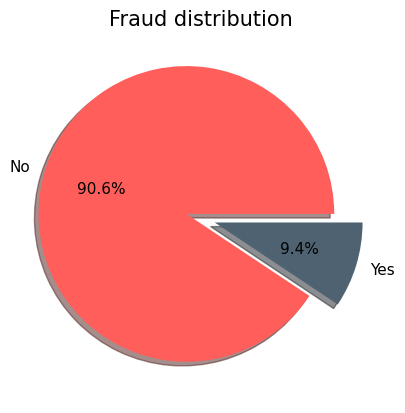

In [38]:
ax = df_temp['PotentialFraud'].value_counts().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True, colors=['#FF5E5B', '#4F6272'],textprops = {'fontsize':11}).set_title("Fraud distribution",  fontsize = 15)
plt.ylabel('')
plt.show()

plt.show()

In [39]:
#Check data if any null columns
df_temp.isna().sum()

,0
InscClaimAmtReimbursed_In,0
AttendingPhysician_In,0
OperatingPhysician_In,0
OtherPhysician_In,0
DeductibleAmtPaid_In,0
ClmDiagnosisCode_1_In,0
ClmDiagnosisCode_2_In,0
ClmDiagnosisCode_3_In,0
ClmDiagnosisCode_4_In,0
ClmDiagnosisCode_5_In,0


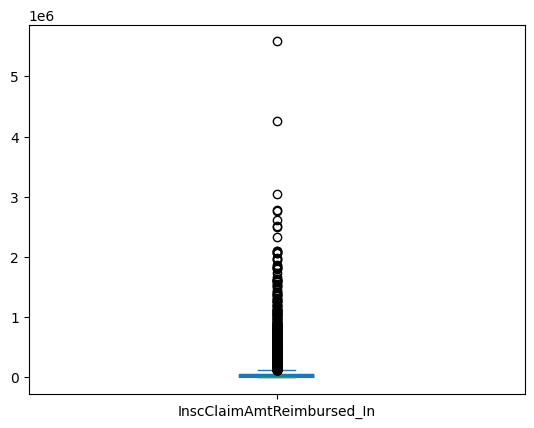

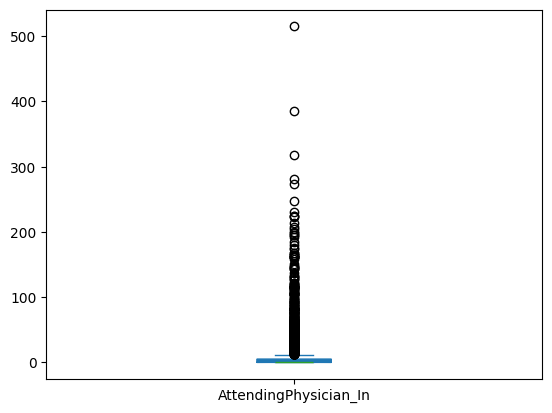

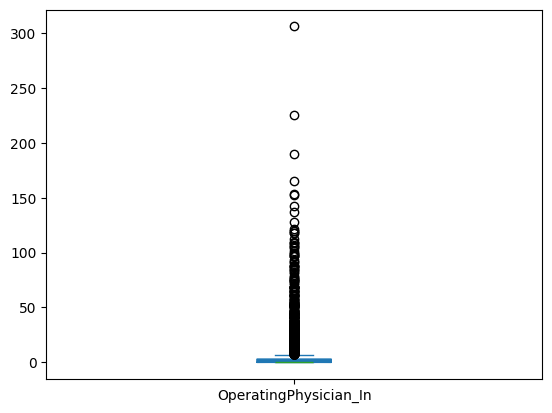

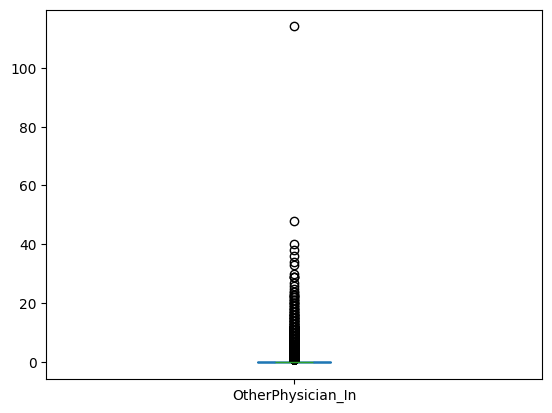

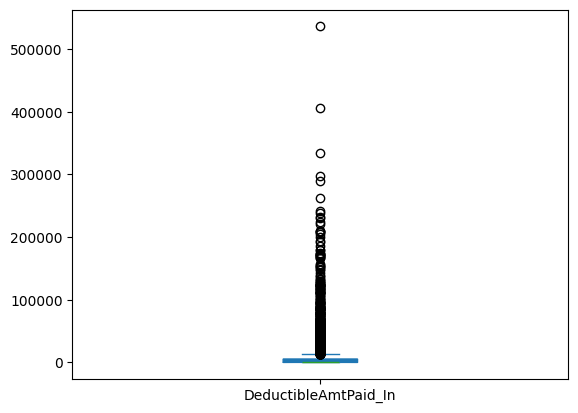

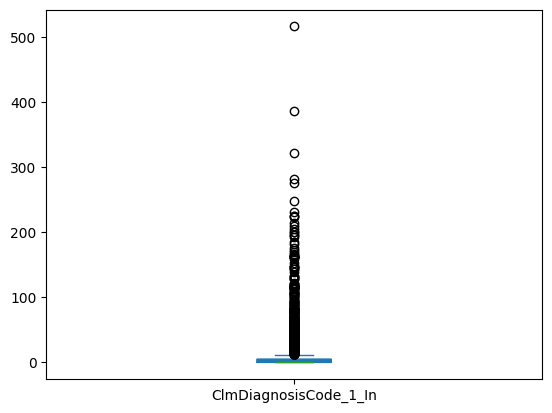

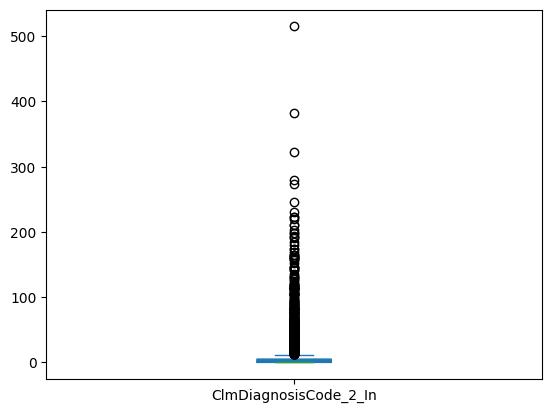

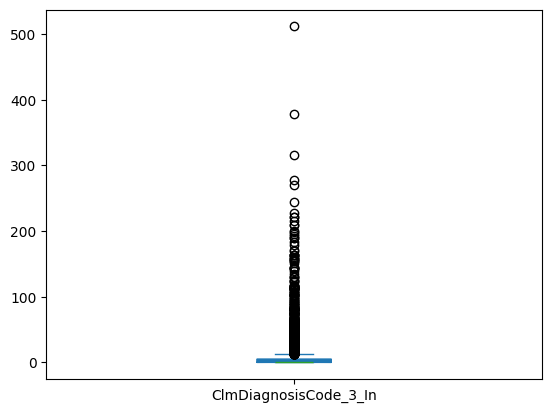

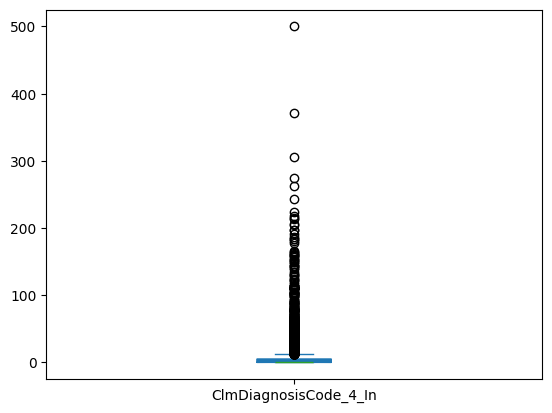

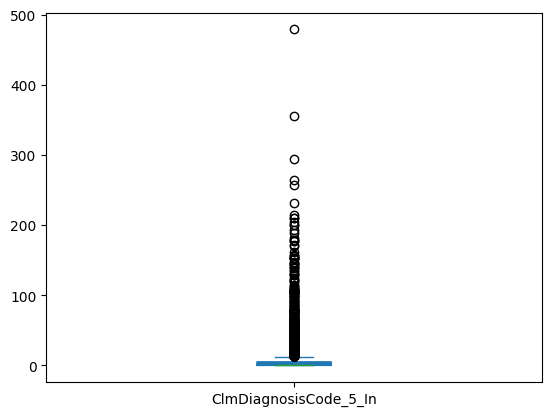

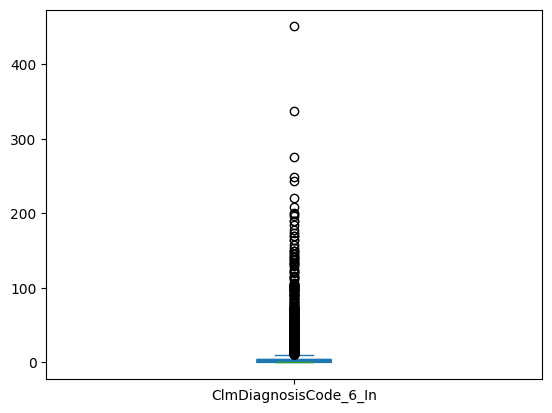

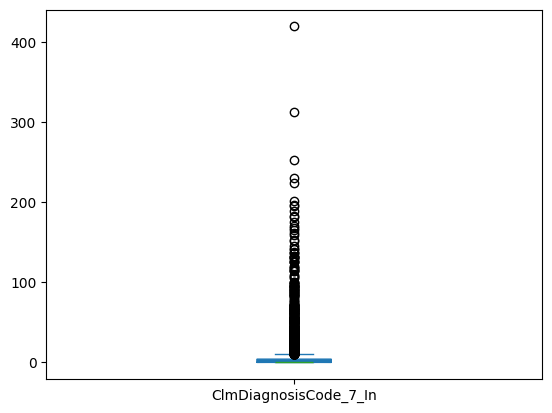

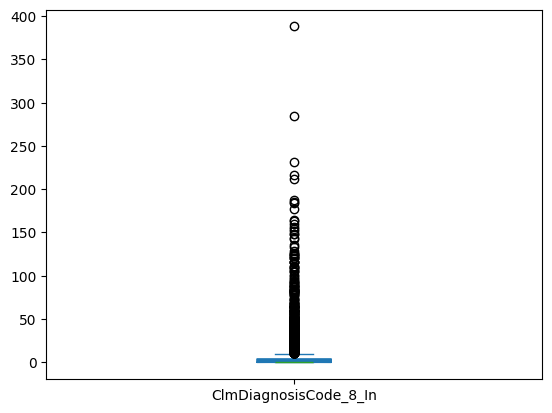

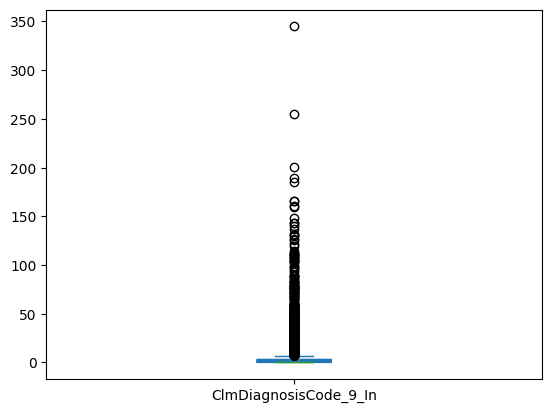

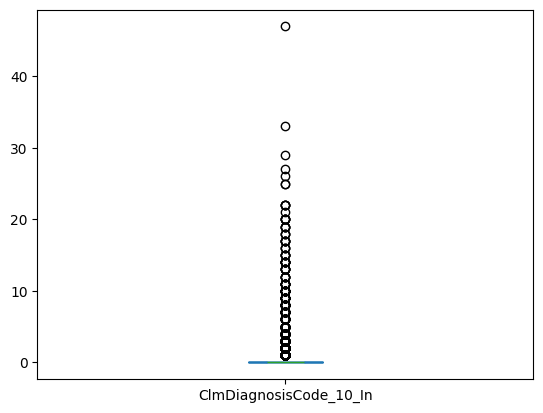

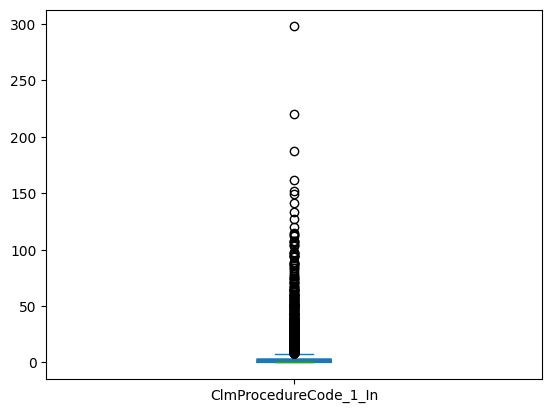

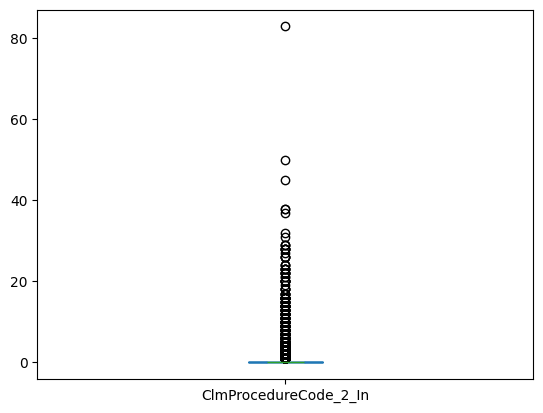

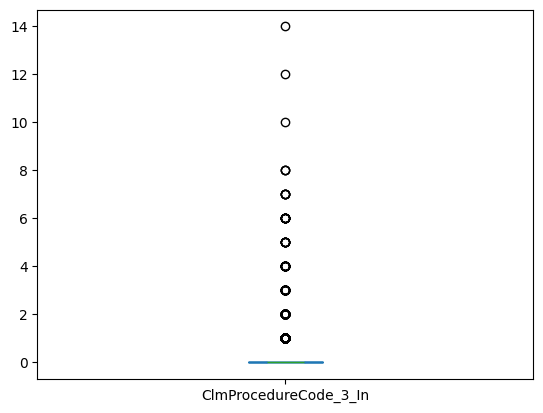

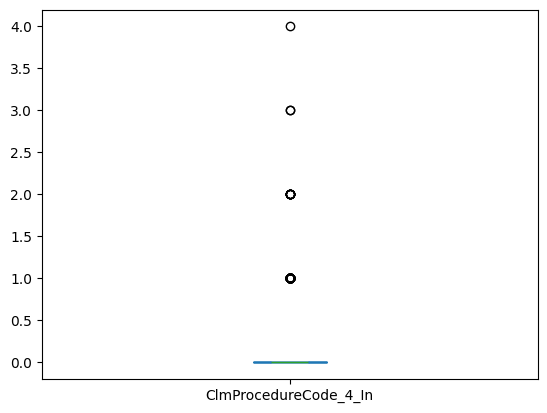

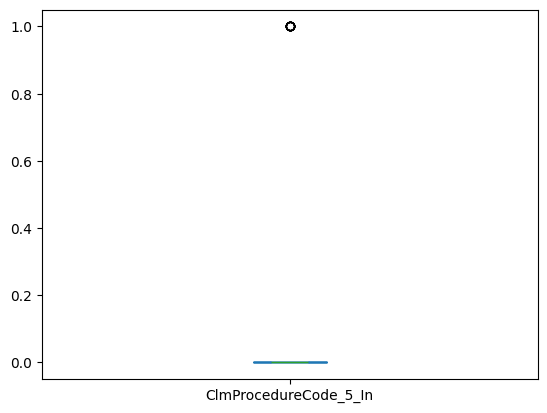

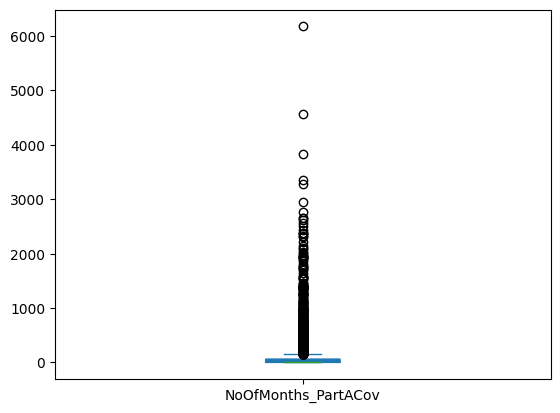

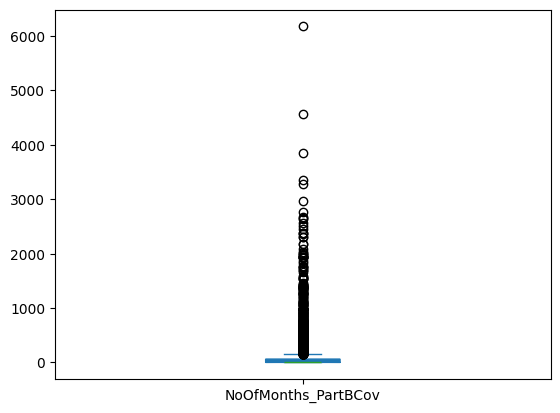

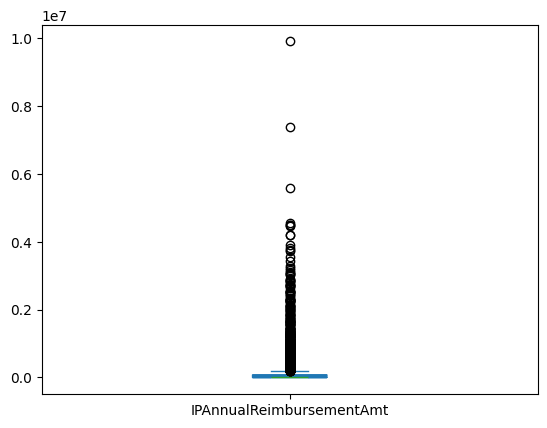

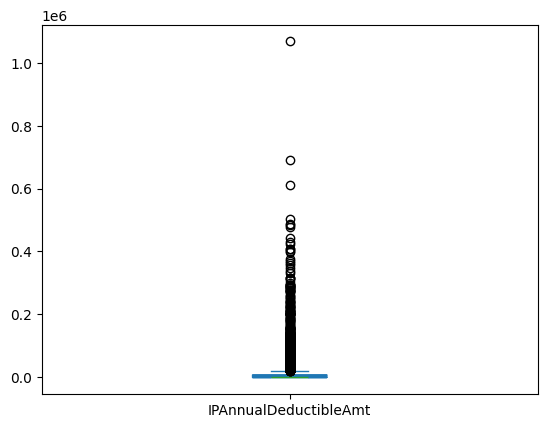

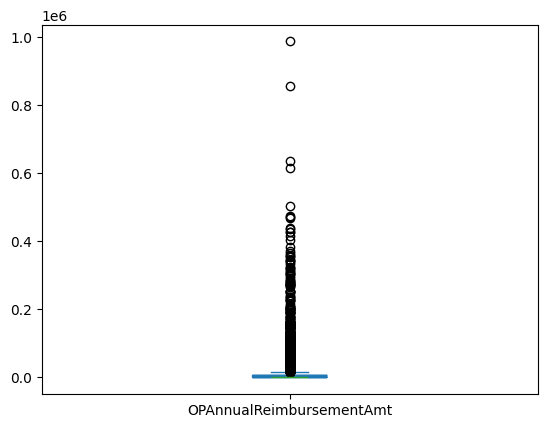

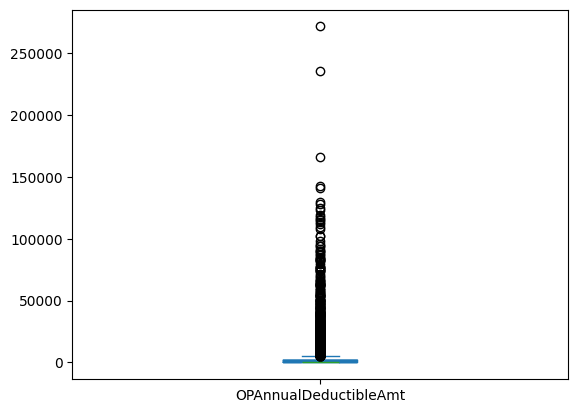

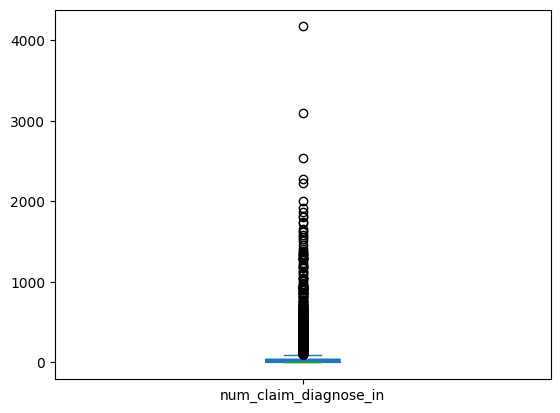

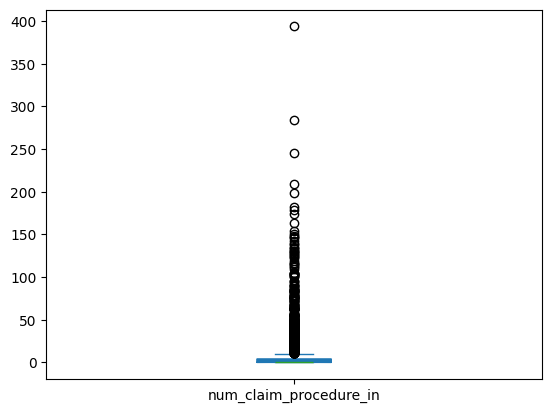

In [40]:
# split data into features and target and then train and test.
df_temp["PotentialFraud"] = df_temp["PotentialFraud"].map({"Yes" : 1,"No" : 0})
df_temp = df_temp[df_temp["PotentialFraud"].notna()]
X_train_val = df_temp.drop(columns = "PotentialFraud")
y_train_val = df_temp["PotentialFraud"]


select_test = [i for i in select_cols if i != 'PotentialFraud'] + ["Provider"]
select_test = [col for col in select_test if col in df_test.columns]
test = df_test[select_test]


test = test.loc[:,~test.columns.duplicated()]

id_test = test[["Provider"]]
X_input = test.drop(columns = ["Provider"], axis = 1)

#check outlier

num_cols = [i for i in X_train_val.columns if X_train_val[i].dtypes == 'float64' or X_train_val[i].dtypes == 'int64' if i[:11] != 'ChronicCond']

for feature in df_temp[num_cols]:
    df_temp[feature].plot(kind='box', notch=True, patch_artist=True)
    plt.show();

In [41]:
num_cols = [i for i in X_train_val.columns if X_train_val[i].dtypes == 'float64' or X_train_val[i].dtypes == 'int64']



num_transform = Pipeline([
                                    ("scaler", RobustScaler())
])


prep_pipeline =  ColumnTransformer([
    ('num trans', num_transform, num_cols)
])



# Modeling

# Logistic Regression

In [42]:
model_lr = imbpipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lr',LogisticRegression())
])

# Random Forest

In [43]:
model_rf = imbpipeline([
    ('prep', prep_pipeline),
    ('rf', RandomForestClassifier(
        n_estimators=3,
        max_depth=2,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features=1,
        bootstrap=True,
        max_samples=0.2,
        class_weight='balanced_subsample',
        random_state=0
    ))
])

# Decision Tree

In [44]:
model_dt = imbpipeline([
    ('prep', prep_pipeline),
    ('dt', DecisionTreeClassifier(
        criterion='entropy',
        max_depth=None,
        min_samples_split=2

    ))
])

# Naive Bayes

In [45]:
model_nb = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=True)),
    ('binarize', Binarizer(threshold=0.0)),
    ('nb', BernoulliNB(alpha=1.0))
])

# Evaluation

In [46]:
def model_evaluation_cv(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train_val, y_train_val, cv = skfold, scoring = metric)
    avg_accuracy = model_cv.mean()
    return avg_accuracy

print('Accuracy Score Evaluation of Logistic Regression : ', model_evaluation_cv(model_lr, 'accuracy'))
print('Accuracy Score Evaluation of Random Forest : ', model_evaluation_cv(model_rf, 'accuracy'))
print('Accuracy Score Evaluation of Decision Tree : ', model_evaluation_cv(model_dt, 'accuracy'))
print('Accuracy Score Evaluation of Naive Bayes : ', model_evaluation_cv(model_nb, 'accuracy'))

Accuracy Score Evaluation of Logistic Regression :  0.8369685767097966
Accuracy Score Evaluation of Random Forest :  0.8523105360443622
Accuracy Score Evaluation of Decision Tree :  0.9029574861367837
Accuracy Score Evaluation of Naive Bayes :  0.7158964879852125
